In [1]:
import nest_asyncio

nest_asyncio.apply()

In [2]:
from pastel.parsers import parse_assertion, parse_evidence, check_grammar
from pastel.helpers import load_images_from_directory

import logfire
import pandas as pd
from IPython.display import display, Markdown
import asyncio

from pastel.reference import GLOSSARY
import os

# Show all rows in pandas DataFrames
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

logfire.configure(token=os.getenv("PYDANTIC_LOGFIRE_TOKEN"))
logfire.instrument_openai()
logfire.instrument_anthropic()

display(Markdown(GLOSSARY))


# Glossary - Insurance Industry Terms and Acronyms

| Term/Acronym | Definition | Description |
|--------------|------------|-------------|
| **EULR** | Estimated Ultimate Loss Ratio | A key performance metric in insurance. Values > 0.7 indicate poor program performance. Estimates what the final loss ratio will be after all claims are settled. |
| **LR** | Loss Ratio | The ratio of incurred losses and loss adjustment expenses to earned premiums. A fundamental metric of insurance profitability - lower is generally better for insurers. |
| **ULR** | Ultimate Loss Ratio | The projected final loss ratio for a given cohort or time period after all claims are fully developed. Similar to EULR but may include different calculation methodologies. |
| **UW** | Underwriting | The process of evaluating risk to determine whether to issue insurance and at what terms. "UW_name" in the data likely refers to an underwriter or underwriting team. |
| **LOB** | Line of Business | A specific type of insurance product or coverage area (e.g., commercial auto liability, property, workers' compensation). Different LOBs have different risk profiles and performance characteristics. |
| **Live Loss Ratio** | Current ratio of losses to premiums | Measures the real-time performance of policies before claims fully mature. In the visualization, this metric is broken down by quarters and underwriting years, with higher values indicating worse performance. |
| **ClaimModel Frequency** | Number of claims filed per policy | Tracks how often claims are filed, measured over the lifetime of policies (in days). Higher values indicate more frequent claims. |
| **Written Premium** | Premium charged per risk unit | The amount charged to policyholders for insurance coverage, typically measured per risk unit and days covered. |
| **ClaimModel Severity** | Financial impact of claims | Measures how costly claims are. The "Large Claims/Total Claims" ratio indicates what portion of claims exceed certain thresholds. |
| **Underwriting Year/Cohort** | Policies written during a specific year | Denoted as 2018, 2019, 2020A, 2020B, etc. The letter suffix likely indicates different quarters or policy periods within a year. |
| **Program** | A specific book of business | A collection of insurance policies with similar characteristics, typically representing a specific product offering to a defined market segment. |
| **Days** | Maturity or development of policies | Represents the time elapsed since policy inception, showing how claims and performance metrics develop over time (up to 1000 days in some visualizations). |
| **IBNR** | Incurred But Not Reported | Claims that have occurred but haven't yet been reported to the insurer. Important for calculating ultimate loss projections. |
| **Cut** | Segment of business | A specific subset or segment of the insurance portfolio, used for more granular analysis (e.g., "the long distance segment" mentioned in example insight). |
| **Q1-Q4** | Quarters 1-4 | Calendar quarters used to organize and analyze insurance performance data. |
| **Year-Letter Designation<br>(e.g., 2022A, 2022B)** | Underwriting cohort within a year | Rather than just annual cohorts, these likely represent specific policy issuance periods within a year - possibly quarters, trimesters, or even custom underwriting cycles. For example, 2022A might be Q1 of 2022, 2022B might be Q2, and 2022C might be Q3. The lack of consistency in how many letter designations appear per year (some years have A, B, C while others just have A, B or no letters) suggests these might correspond to specific underwriting initiatives, product revisions, or pricing changes rather than strictly calendar periods. This more granular segmentation allows insurers to track how specific cohorts perform over time, especially when changes to underwriting criteria or pricing were implemented mid-year. |
| **Severity Ratio** | Ratio of large claims to total claims | This metric measures what proportion of total claims exceed a certain threshold (likely the $50K and $100K thresholds mentioned in the chart). It helps insurers understand if their losses are driven by a few large claims or many smaller ones. A rising severity ratio indicates that large claims are becoming more common relative to the total claim count, which could signal increasing risk exposure or changing claim patterns. The chart tracks this ratio's development over time (days) for different underwriting cohorts, showing how the proportion of large claims evolves as policies mature. |
| **NSA Program** | Non-Standard Auto Program | Most likely refers to an auto insurance program for high-risk drivers who don't qualify for standard auto insurance coverage. NSA typically covers drivers with poor driving records, multiple accidents or violations, DUIs, or other factors that make them higher risk. Alteratively, a program that covers vehicles not typically covered by standard auto insurance policies, such as modified vehicles, classic cars, or high-performance sports cars. |


In [3]:
lrs = pd.read_excel("../data/lrs.xlsx")
insights = pd.read_excel("../data/Insights.xlsx")

sample_programnames = [
    "pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw",
    "zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe",
]

display(Markdown("# Loss Ratio Data Set"))
display(Markdown("**Spreadsheet:** lrs.xslx"))
display(lrs.query("programname in @sample_programnames"))
display(Markdown("<br><br>"))

display(Markdown("# Insights Data Set"))
display(Markdown("**Filename:** Insights.xlsx"))
# display(insights.query("programname in @sample_programnames"))
display(insights)

Logfire project URL: ]8;id=67918;https://logfire.pydantic.dev/xmandeng/pastel\https://logfire.pydantic.dev/xmandeng/pastel]8;;\

# Loss Ratio Data Set

**Spreadsheet:** lrs.xslx

,programname,uw_name,lr,ulr
0,pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw,2021,0.92,0.99
1,pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw,2022,0.59,0.86
2,pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw,2023,0.29,0.76
3,pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw,2024,0.02,NaN
7,zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe,2018,1.43,1.45
8,zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe,2019,1.19,1.22
9,zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe,2020A,1.35,1.41
10,zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe,2020B,0.78,0.90
11,zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe,2021A,0.65,0.77
12,zOh+1hfGBc0APeN39xBT9Gw3m4vCj5fzPe4I4Ix86FlsyGY2I2GRkqPVee1eQqQe,2021B,0.85,1.02


<br><br>

# Insights Data Set

**Filename:** Insights.xlsx

,programname,insight,line_of_business,Internal,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw,This is a poorly performing auto liability program (EULR > 0.7) with stable pricing and similar performance for frequency and severity of claims across underwriting years.,Commercial Auto Liability,right,NaN,NaN,done
1,08slGxClIGb9SlS83ieOFBYvIleE1CgdGCeW10xor3+UP6iinit+MeIgqXRRnv9F,"This is a well-performing trucking program (EULR < 0.7) consisting predominantly of auto liability risk (LOB 19.4, 21.2). Performance is consistent or improving by underwriting cohorts due to a reduction in frequency. Risk is entirely concentrated in CA.",Commercial Auto Liability,right,NaN,NaN,done
2,MCpdUuJ2yLq1+K4hxHkHmwcYoWdfcxDF+0Qy9KAopCg=,"This is a NSA program with EULR < 0.7. The policies written in FL appear to have higher loss ratios than other states. Premium growth has slowed in H2 2024. Finally, there is a considerable increase in price in the most recent months.",Private Auto: Non-standard,right,NaN,NaN,done
3,aJgyorFdgAf8I37PZ84R2inxAAkSSLUD/BSdh7FDJuE=,"The book is long-tailed and performance is driven by severe losses, giving high variance to forecasts. The recent underwriting years may be more profitable, driven by a reduction in severity. No major patterns are apparent.",Commercial Auto Liability,right/ different style. Has extra information,NaN,NaN,done
4,oxSOU23ZPwS6p26JWzjrC2VVdJYbhkvK2KYOsKGisyZWfyDMzhRyzBUWKQ9NdQH/,The book is long-tailed and profitable. The first underwriting year has produced worse than predicted results but the following years appear to be performing better on both severity and frequency of claims. Performance is driven by some relatively severe losses and the projections have high variance. Pricing has strengthen every treaty year which is consistent with improved LR.,General Liability,wrong,NaN,NaN,done
5,mEcKY+P4qKrN8eAIHM3ZjvqGuRf96I7bdKdNORYlcdE=,This is a highly inconsistent and largely underperforming trucking liability book. Underwriting predominantly focuses on TX policyholders.,Commercial Auto Liability,right,NaN,NaN,done
6,Z8rSOymnjpW1HhwWUR/cxen4c7R84sokre43IQ9pLwI=,Dogs are friendly animals and you can observe them in trucking liability books.,Commercial Auto Liability,wrong,NaN,NaN,done
7,0wvTBiDyAsazB20qDhyomFS505t1ko+Dne/eZsDtqddeA4/SnAMhg8Bctev9RGU1,The book is long-tailed and profitable. The first underwriting year has produced worse than predicted results but the following years appear to be performing better on both severity and frequency of claims. Performance is driven by some relatively severe losses and the projections have high variance. Pricing has strengthen every treaty year which is consistent with improved LR.,General Liability,right,NaN,NaN,done
8,vbOJFqJ0BOzEXIi9uBzgow+z55EcdgzYq6ntebANax8=,This is a NSA program with EULR < 0.7. The policies written in FL appear to have higher loss ratios than other states. There is a considerable increase in price in the most recent months.,Private Auto: Non-standard,right,NaN,NaN,done
9,CjjbUkCiNHFSunlwypkIRKSrXNcgPjgsVaq7Wx44Lt4/ZaapBaB0I6yipszty0MZ,This is a well performing auto liability program (EULR > 0.7) with stable pricing and similar performance for frequency and severity of claims across underwriting years.,Commercial Auto Liability,wrong,NaN,NaN,done


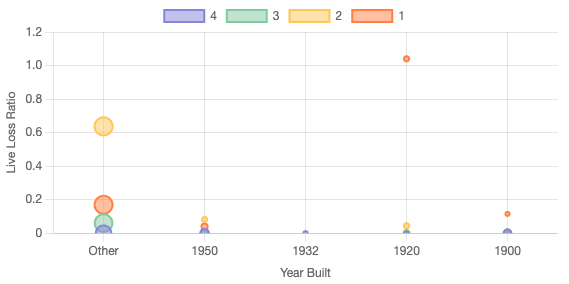

**Base64 Encoding**: */9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0 ...*

In [4]:
image_dir = "../data/0wvTBiDyAsazB20qDhyomFS505t1ko+Dne-eZsDtqddeA4-SnAMhg8Bctev9RGU1"
images = load_images_from_directory(image_dir)

index = -1

display(images[index].image)
display(Markdown("**Base64 Encoding**: *" + images[index].encoded[:75] + " ..." + "*"))

In [5]:
tasks = [asyncio.create_task(parse_assertion(insight)) for insight in insights["insight"]]
insights["conclusions"] = await asyncio.gather(*tasks)

06:15:39.103 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.107 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.111 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.116 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.120 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.123 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.126 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.129 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.132 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.135 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.138 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.140 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.143 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.145 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:39.148 Chat Completion with 'gpt-4o-mini' [LLM]


In [6]:
tasks = [
    asyncio.create_task(parse_evidence(row.conclusions, row.insight))
    for row in insights.itertuples()
]
insights["pastels"] = await asyncio.gather(*tasks)

06:15:41.548 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.553 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.559 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.563 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.566 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.569 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.572 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.575 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.578 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.581 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.584 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.586 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.589 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.592 Chat Completion with 'gpt-4o-mini' [LLM]
06:15:41.596 Chat Completion with 'gpt-4o-mini' [LLM]


In [7]:
tasks = [asyncio.create_task(check_grammar(insight.strip())) for insight in insights["insight"]]
insights["grammar"] = await asyncio.gather(*tasks)

06:15:44.971 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:44.973 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:44.976 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:44.982 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:44.985 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:44.988 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:44.990 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.006 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.020 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.054 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.058 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.060 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.064 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.070 Message with 'claude-3-5-sonnet-latest' [LLM]
06:15:45.080 Message with 'claude-3-5-sonnet-latest' [LLM]


In [8]:
insights[["programname", "insight", "pastels", "grammar"]].style.set_properties(
    **{"text-align": "left"}
).set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])

,programname,insight,pastels,grammar
0,pdl6muw8mJl9DL7bVO40nFOroodOnSFBG5e7zw+nAW32k7BiKehq6oLHwyItBjfw,This is a poorly performing auto liability program (EULR > 0.7) with stable pricing and similar performance for frequency and severity of claims across underwriting years.,"evidence=['The Expected Ultimate Loss Ratio (EULR) is greater than 0.7.', 'The program has stable pricing.', 'There is similar performance for frequency of claims across underwriting years.', 'There is similar performance for severity of claims across underwriting years.'] conclusion='This is a poorly performing auto liability program'",errors=[]
1,08slGxClIGb9SlS83ieOFBYvIleE1CgdGCeW10xor3+UP6iinit+MeIgqXRRnv9F,"This is a well-performing trucking program (EULR < 0.7) consisting predominantly of auto liability risk (LOB 19.4, 21.2). Performance is consistent or improving by underwriting cohorts due to a reduction in frequency. Risk is entirely concentrated in CA.","evidence=['The Expected Ultimate Loss Ratio (EULR) is less than 0.7.', 'The program consists predominantly of auto liability risk (LOB 19.4, 21.2).', 'Performance is consistent or improving by underwriting cohorts due to a reduction in frequency.', 'Risk is entirely concentrated in CA.'] conclusion='This is a well-performing trucking program'",errors=[]
2,MCpdUuJ2yLq1+K4hxHkHmwcYoWdfcxDF+0Qy9KAopCg=,"This is a NSA program with EULR < 0.7. The policies written in FL appear to have higher loss ratios than other states. Premium growth has slowed in H2 2024. Finally, there is a considerable increase in price in the most recent months.","evidence=['The policies written in FL appear to have higher loss ratios than other states.', 'Premium growth has slowed in H2 2024.', 'There is a considerable increase in price in the most recent months.'] conclusion='This is a NSA program with EULR < 0.7.'",errors=[]
3,aJgyorFdgAf8I37PZ84R2inxAAkSSLUD/BSdh7FDJuE=,"The book is long-tailed and performance is driven by severe losses, giving high variance to forecasts. The recent underwriting years may be more profitable, driven by a reduction in severity. No major patterns are apparent.","evidence=['The book is long-tailed and performance is driven by severe losses, giving high variance to forecasts.', 'The recent underwriting years may be more profitable, driven by a reduction in severity.'] conclusion='No major patterns are apparent.'",errors=[]
4,oxSOU23ZPwS6p26JWzjrC2VVdJYbhkvK2KYOsKGisyZWfyDMzhRyzBUWKQ9NdQH/,The book is long-tailed and profitable. The first underwriting year has produced worse than predicted results but the following years appear to be performing better on both severity and frequency of claims. Performance is driven by some relatively severe losses and the projections have high variance. Pricing has strengthen every treaty year which is consistent with improved LR.,"evidence=['The first underwriting year has produced worse than predicted results.', 'The following years appear to be performing better on both severity and frequency of claims.', 'Performance is driven by some relatively severe losses.', 'The projections have high variance.', 'Pricing has strengthened every treaty year which is consistent with improved LR.'] conclusion='The book is long-tailed and profitable.'","errors=[""'strengthen' should be 'strengthened' - incorrect verb tense""]"
5,mEcKY+P4qKrN8eAIHM3ZjvqGuRf96I7bdKdNORYlcdE=,This is a highly inconsistent and largely underperforming trucking liability book. Underwriting predominantly focuses on TX policyholders.,evidence=['Underwriting predominantly focuses on TX policyholders.'] conclusion='This is a highly inconsistent and largely underperforming trucking liability book.',errors=[]
6,Z8rSOymnjpW1HhwWUR/cxen4c7R84sokre43IQ9pLwI=,Dogs are friendly animals and you can observe them in trucking liability books.,evidence=['You can observe them in trucking liability books.'] conclusion='Dogs are friendly animals.',errors=[]
7,0wvTBiDyAsazB20qDhyomFS505t1ko+Dne/eZsDtqddeA4/SnAMhg8Bct